$
 \newcommand{\wv}{\mathbf{w}}
 \newcommand{\Tm}{\mathbf{T}}
 \newcommand{\Xm}{\mathbf{X}}
$

# Neural Networks - Regression (Workbook)

### ITCS 4156
### Minwoo "Jake" Lee

# Goal

The goal of this activity is to implement a very basic neural network which applies nonlinear regression. The dataset we will be working with this week is [the allometry of tree root biomass data](https://figshare.com/articles/_The_Allometry_of_Coarse_Root_Biomass_Log_Transformed_Linear_Regression_or_Nonlinear_Regression_/817238). Our goal will be to compare how well our new nonlinear regression method compares to our previously learned method of linear regression.

Follow the TODO titles and comments to finish the activity! 

# Agenda

1. Data Loading, Preprocessing, and Visualization
    * Downloading, Loading, and Preprocessing
    * Data Visualization
    * Data Partitioning
* Apply Linear Regression: Least Squares
* Apply Nonlinear Regression: Neural Networks
    * Variables
    * Forward Pass Steps
    * Backward Pass Equations

In [1]:
from copy import deepcopy as copy
from IPython.core.debugger import set_trace

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# Data Loading, Preprocessing, and Visualization

So why use tree root biomass data? Better yet, what even is tree root biomass? Root biomass is a fancy way of referring to the weight of a root. It turns out that root biomass is a good way to measure the potential accumulated carbon in a tree's roots. Thus, if we want to predict the potential accumulated carbon in a tree's root system then we need to predict the tree's root biomass. This indirect prediction of accumulated carbon via predicting root biomass is called allometry.

So once again, why use root biomass data? It turns out that digging up every tree in a forest and measuring every trees' roots biomass might be implausible and counterproductive. It also turns out prior work on this issue has shown that there seems to be a linear correlation between root biomass and the root diameter (DBH). Even more recent work seems to indicate that predicting biomass based on root diameter might even have a nonlinear correlation. This sounds like a pretty good dataset to test the differences of linear regression and our newly learned method of nonlinear-regression.

Knowing this, we want to apply linear and nonlinear regression to predict tree root biomass: given two parameters: type of tree and root diameter.

Below is an brief excerpt from the description of the tree root biomass dataset.
> Precise estimation of root biomass is important for understanding carbon stocks and dynamics in forests. Traditionally, biomass estimates are based on allometric scaling relationships between stem diameter and coarse root biomass calculated using linear regression (LR) on log-transformed data. Recently, it has been suggested that nonlinear regression (NLR) is a preferable fitting method for scaling relationships. But while this claim has been contested on both theoretical and empirical grounds, and statistical methods have been developed to aid in choosing between the two methods in particular cases, few studies have examined the ramifications of erroneously applying NLR

## Downloading, Loading, and Preprocessing

You can download the allometry of tree root biomass data using the following link [here](https://figshare.com/articles/_The_Allometry_of_Coarse_Root_Biomass_Log_Transformed_Linear_Regression_or_Nonlinear_Regression_/817238). Once you have downloaded the data you will need to unzip the dataset and store the datafile `Appendix_S1.csv` in the same folder as this notebook! 

Okay, the first step is to load our tree root biomass data into a **Pandas DataFrame object**. 

In [2]:
tree_biomass_file = 'Appendix_S1.csv'
tree_df = pd.read_csv(tree_biomass_file)

Keep in mind that anytime you see a variable with 'df' in the name it is safe to assume that said variable is a Pandas DataFrame - we'll try to keep our naming scheme consistent. Remember that we must use `iloc` and `loc` to index a Pandas DataFrame!

Let's print out the `tree_df` DataFrame and see what our data looks like.

In [3]:
tree_df

,sp,dbh,rootbiomass
0,Castanopsis eyrei,1.08,0.16
1,Castanopsis eyrei,1.85,0.15
2,Castanopsis eyrei,2.46,0.46
3,Castanopsis eyrei,2.60,1.08
4,Castanopsis eyrei,4.46,1.34
...,...,...,...
154,Schima superba,32.92,253.57
155,Schima superba,34.00,122.55
156,Schima superba,37.20,136.30
157,Schima superba,38.00,181.13


So here we go, we can see our two train features: tree type (sp) and root diameter (dbh).  Likewise, we can also see our target feature root biomass (rootbiomass).

Let's take a closer look the tree types and see how many types of trees there are. We can do so by using Pandas `.unique()` method on the tree type column 'sp'. This will extract out all the unique tree names stored in the tree type column 'sp'.

In [5]:
tree_df['sp'].unique()

array(['Castanopsis eyrei', 'Pinus massoniana', 'Schima superba'],
      dtype=object)

There we go, we can now see that there are three tree types: 'Castanopsis eyrei', 'Pinus massoniana', 'Schima superba'.

Ah, but notice that our tree types are strings! Remember, having strings in our data doesn't fair well for training our algorithms. Thus, we must once again convert our strings to indicator variables (one-hot encodings).

### TODO: 
Let's now convert our strings to indicator variables so we can use tree type in our linear and nonlinear regression algorithms. Here we'll try using the Pandas `pd.get_dummies()` function to quickly create indicator variables for our strings.

1. Using the `pd.get_dummies()` function index the tree type column 'sp' in our `tree_df` and convert it to indicator variables (one-hot encodings). Store this output into the `tree_type_dummies` variable.
    1. Hint: Want to quickly know how the ` pd.get_dummies()` function works? Try uncommenting and running the code cell with `?pd.get_dummies` to see its documentation!

In [6]:
# ?pd.get_dummies

In [7]:
# TODO (1)
tree_type_dummies = 
tree_type_dummies

,Castanopsis eyrei,Pinus massoniana,Schima superba
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
154,0,0,1
155,0,0,1
156,0,0,1
157,0,0,1


Now let's stitch our training features back together into a variable called `X`. To do so we need to combine the indicator variables in `tree_type_dummies` with the root diameter (dbh) feature using the `pd.concat()` function. Recall that `pd.concat()` takes as input a list of DataFrame instances that you wish to combine. Also recall, that we want to vertically stack our data! Thus, we must set the 'axis' parameter to 1 (axis 0 corresponds to stacking horizontally while axis 1 corresponds to stacking vertically).

In [8]:
X = pd.concat([tree_type_dummies, tree_df['dbh']], axis=1)
X

,Castanopsis eyrei,Pinus massoniana,Schima superba,dbh
0,1,0,0,1.08
1,1,0,0,1.85
2,1,0,0,2.46
3,1,0,0,2.60
4,1,0,0,4.46
...,...,...,...,...
154,0,0,1,32.92
155,0,0,1,34.00
156,0,0,1,37.20
157,0,0,1,38.00


Next, let's extract the target column 'rootbiomass' which corresponds to tree root biomass.  The below code simply access the 'rootbiomass' column and copies it into the variable `T`. Note, that we add double squared brackets `tree_df[['rootbiomass']].copy` so that when we call `T.values` a Numpy array with two dimensions, i.e. (158, 1), will be returned. Otherwise, if we only add single brackets `tree_df['rootbiomass'].copy` then when we call `T.values` a Numpy array with one dimension, i.e (158,), will be returned. **Remember always, ALWAYS, be thinking about your data shapes.**

In [9]:
T = tree_df[['rootbiomass']].copy()  # need extra square brackets not to lose 2d shape (or dataframe)
T

,rootbiomass
0,0.16
1,0.15
2,0.46
3,1.08
4,1.34
...,...
154,253.57
155,122.55
156,136.30
157,181.13


## Data Visualization

You knew we had to have some data visualization at some point. So, before moving on to linear regression and nonlinear regression let's take a second to visualize the correlation between our features using some neat Pandas specific functions.

To start let's take a look at how our feature root diameter 'dbh' and our target root biomass 'rootbiomass' might correlate to one-another. There is a cool Pandas plotting function called `scatter_matrix` that let's us quickly plot features against each other (this is similar to what we did back in our first lab on data visualization). In addition, on the main diagonal instead of plotting the identical features against each other it plots the distribution of the data.

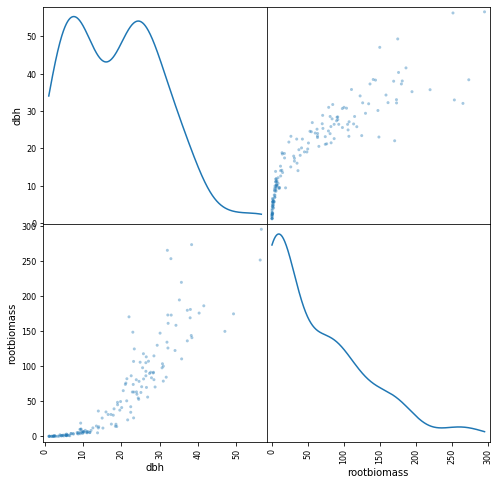

In [10]:
from pandas.plotting import scatter_matrix

scatter_matrix(tree_df, alpha=0.4, figsize=(8,8), diagonal='kde',);

The plots on the main diagonal represent the distribution of the data. For example, when looking at `dbh` plotted against itself, i.e. the first plot, we can see the most frequent values for `dbh` are around ~10 and ~25 on the x-axis. On the off-diagonal we can see the plots for features plotted against each other (each side of the off-diagonal is essentially a reflection of the other side). Here we can look for correlations between features.

Next, let's plot the same scatter matrix but this time let's add in tree types. To do so, we simply combine our `X` and `T` DataFrames, defined above, and then pass this concatenation to the `scatter_matrix()` function. Remember, `X` contains our tree type indicator variables and root diameter features while `T` contains root biomass.

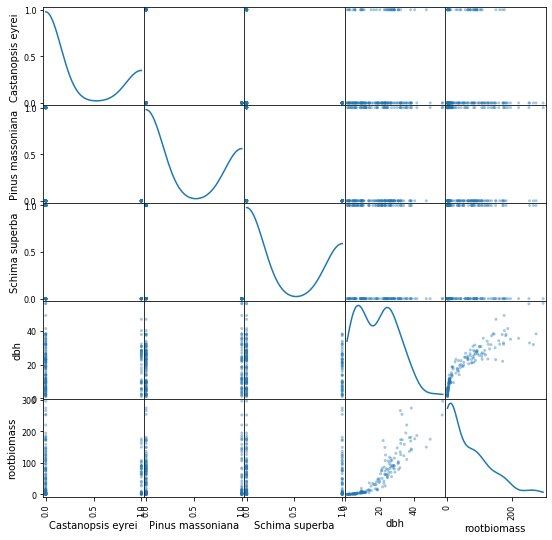

In [11]:
Data = pd.concat([X, T], axis=1)
scatter_matrix(Data, alpha=0.4, figsize=(9,9), diagonal='kde');

We can see our original plot is in the bottom right-hand corner. As stated before, the main diagonal represents data distribution for each feature. Meanwhile, on the off-diagonal we can see the plots for features plotted against each other. 

We can see that when the tree type variables are plotted against each other there are only three plotted points. For example, check out when 'Castanopsis eyrei' is plotted against 'Pinus massoniana'. We can see on the y-axis the point plotted at (0, 1) is for 'Castanopsis eyrei' and on the x-axis we can see the point plotted at (1, 0) is for 'Pinus massoniana'. At (0, 0) we can see the "other" tree types that aren't 'Castanopsis eyrei' or 'Pinus massoniana' (in this case, this is only the tree type 'Schima superba').

However, when looking at each tree type plotted against ‘dbh’ or ‘rootbiomass’ we can see the spread of each trees' root diameter or biomass values. Take the bottom left plot for example. Here 'Castanopsis eyrei' is plotted against 'rootbiomass'. Looking at the x-axis we can see 0 indicates all other tree types, while 1 indicates 'Castanopsis eyrei'. Now, looking at the y-axis we can see the spread of the root diameter values. It seems  'Castanopsis eyrei' root diameter values seem to be concentrated under 200!

### Taking a Closer Look at Root Diameter and Biomass Spread

Let's now take a closer look at how the root diameter and biomass spread changes per tree type, as we noticed in the scatter matrix plots. Let's simply create two line graphs using Pandas `.plot()` method. One plot will be for our training features `X` and one plot will be for our target `T`.

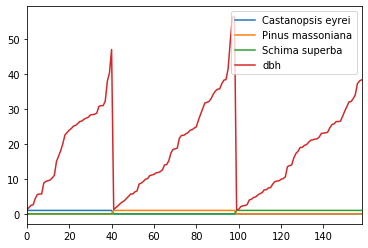

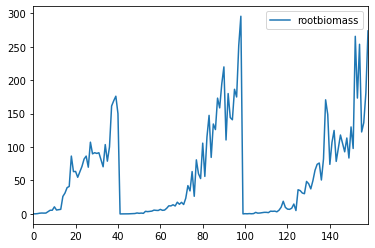

In [12]:
X.plot()
T.plot()

Welp, it is kinda hard to tell which root diameter and biomass values are associated with each tree type. However, we can decipher a change in class when we see the 'dbh' suddenly drop to an extremely low value. For example, we could argue that the x-axis values of 40 and 100 mark the separation between classes for both our plots.

There must be a better way to plot our data. Indeed there is! To do so we can first plot our original DataFrame `tree_df` to plot all our features, including our target. Then we can use our `tree_type_dummies` DataFrame, which contains the indicator variables for the tree types, to color in areas of the graph that correspond to each tree. We can using the Pandas DataFrame `plot()` method to plot our `tree_df` and the `plot.area()` method to color in our graph. The last thing we need to do is scale the values of `tree_type_dummies` to fill in the entire graph up to the potential max y-values. (Remember `tree_type_dummies` only contains 1s and 0s so by default the `plot.area()` would only fill from 0 to 1!)

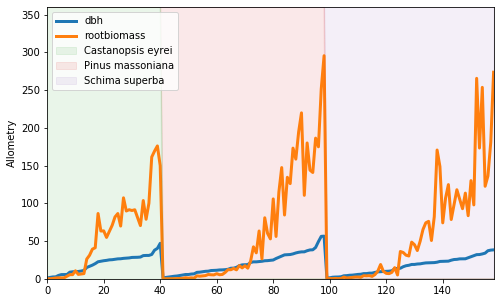

In [13]:
scale_y_axis = 1.2
# Find the max y-value and scale it
max_y_value = np.round(np.max(Data.max().values), decimals=-2) * scale_y_axis 

ax = tree_df.plot(linewidth=3, figsize=(8,5)) # plots all features 
(tree_type_dummies * max_y_value).plot.area(ax=ax, alpha=0.1) # colors in graph
plt.ylim([0, max_y_value]) # sets the y-axis min and max values
plt.ylabel("Allometry"); # the ; here surpresses output

There we go! Now we can get a much better visualization of each trees' root diameter and root biomass values. In addition, we can see how these values compare to one another!

## Data Partitioning
Like always we need to split our data into train and test partitions.

The below code is the `partition()` function we used last week. Recall, that the `partition()` function takes as input the following **Numpy arrays** `X` and `T`. The output of  `partition()` is a list of data and targets where `Xs` holds our training and testing data partitions and `Ts` holds our training and testing target partitions. The elements of `Xs` and `Ts` are Numpy arrays. 

In [14]:
# now partition the data 

""" partitioning data

    parameters
    -----------
    X        numpy array
             input data to partition
    T        numpy array
             target labels to partition
    raito    list
             list of ratios for partitions (should be summed to 1) 
             the number of return pairs are different
    return
    -------
    
    Xs       list of numpy arrays
    
    Ts       list of numpy arrays
"""
def partition(X, T, ratio=[0.8, 0.2]): 
    
    # Checks to make sure ratio sums to 1
    assert(np.sum(ratio) == 1)
    
    # Store the number of data samples 
    N = X.shape[0]

    # change the 1d array to 2d if need
    if len(T.shape) == 1:
        T = T.reshape((N,1))
    
    # Shuffle the data indices 
    idxs = np.random.permutation(N)
        
    Xs = []
    Ts = []
    i = 0  # first index to zero
    for k, r in enumerate(ratio):
         # Number of rows that corresponds to kth element in ratios
        nrows = int(round(N * r)) 
        
        # print (i, nrows)
        # If we are on the last ratio simply use the remaining data samples
        if k == len(ratio)-1:
            Xs.append(X[idxs[i:], :])
            Ts.append(T[idxs[i:], :])
        else:
            Xs.append(X[idxs[i:i+nrows], :])
            Ts.append(T[idxs[i:i+nrows], :])
        
        i += nrows
    
    return Xs, Ts

### TODO: 
Complete the `partition_data()` function below which will partition our data into `Xtrain`, `Xtest`, `Ttrain`, and `Ttest` when called. Notice we pass Numpy arrays to our partition function using `X.values` and `T.values`. Thus, we can expect Numpy arrays to be stored within the lists `Xs` and `Ts`.

1. Split the `data` output from the `partition()` function into `Xtrain`, and `Xtest`
2. Split the `targets` output from the `partition()` function into `Ttrain`, and `Ttest`

In [15]:
def partition_data():
    """Partition data into train and test splits."""
    global Xtrain, Xtest, Ttrain, Ttest
    data, targets = partition(copy(X.values), copy(T.values))
    # TODO: Fill in the right had side of the assignments below
    Xtrain, Xtest = 
    # TODO: Fill in the right had side of the assignments below
    Ttrain, Ttest = 

In [16]:
partition_data()
print("Train data shape: {}".format(Xtrain.shape))
print("Train target shape: {}".format(Ttrain.shape))
print("Test data shape: {}".format(Xtest.shape))
print("Test target shape: {}".format(Ttest.shape))

Train data shape: (127, 4)
Train target shape: (127, 1)
Test data shape: (32, 4)
Test target shape: (32, 1)


 Before we end this section let's define some variables that'll be used later on. Here we set `N` to store the total number of data samples and `D` to store the total number of features. Likewise, we set `Ntrain` to store the total number of training data samples and `Ntest` to store the total number of testing data samples.

In [17]:
N = X.shape[0] # Number of data samples
D = X.shape[1] # Number of data features
Ntrain = Xtrain.shape[0] # Number of train data samples
Ntest = Xtest.shape[0] # Number of test data samples
print("N = {} data samples".format(N))
print("D = {} data features".format(D))
print("Ntrain = {} training data samples".format(Ntrain))
print("Ntest = {} testing data samples".format(Ntest))

N = 159 data samples
D = 4 data features
Ntrain = 127 training data samples
Ntest = 32 testing data samples


##  Apply Linear Regression: Least Sqaures
Now to the algorithms. First, let's start by setting a baseline for our nonlinear neural network using least squares (LS). This baseline will act as a base level of expectations for how well our nonlinear model will need to preform to asses if it is truly better.

Recall the least squares formula is as follows.

$$
w = (X^T \cdot X)^{-1} \cdot X^T \cdot T
$$

Let's take a quick look at the mean and standard deviation of all of data features to see if we need to standardize (i.e. normalize) any of our features.

In [18]:
X.describe()

,Castanopsis eyrei,Pinus massoniana,Schima superba,dbh
count,159.000000,159.000000,159.000000,159.000000
mean,0.257862,0.364780,0.377358,19.018239
std,0.438840,0.482889,0.486257,12.210006
min,0.000000,0.000000,0.000000,1.080000
25%,0.000000,0.000000,0.000000,8.800000
50%,0.000000,0.000000,0.000000,19.020000
75%,1.000000,1.000000,1.000000,27.215000
max,1.000000,1.000000,1.000000,56.500000


As we can see our tree root diameter column 'dbh' has quite a different mean and standard deviation in comparison to the other features. This indicates to us that we need to standardize the 'dbh' column. Since the tree type features all have similar means and standard deviations we don't actually need to standardize them. A good general rule of thumb is to not standardize indicator values. One reason for this is because the tree type input scale will always be the same, i.e. always 0s and 1s.

If you are confused and want some further reading on why we don't typically standardize indicator variables see this [discussion](https://datascience.stackexchange.com/questions/56444/do-i-need-to-standardize-my-one-hot-encoded-labels). It should be noted that we can standardize indicator variables if we really want to, it is typically unnecessary though.

### TODO: 
Let's standardize our data! Recall we preformed standardization back in the 2-Linear Model lab!

1. Calculate the mean for each `Xtrain` **feature** using `np.mean()`. Store output in `mu`.
    1. Hint: Remember to specify which axis we need to calculate the mean over
2. Calculate the STD for each `Xtrain` **feature** using `np.std()`. Store output in `sigma`.
    1. Hint: Remember to specify which axis we need to calculate the STD over
    
Note: Recall `axis=0` corresponds to calculating the mean/STD over all the rows for each column, while `axis=1` corresponds to calculating the mean/STD over all the columns for each row. See this [Pizza post](https://piazza.com/class/k5ckxp40u5r5rx?cid=74) for more details on how the ‘axis’ parameter works.

In [19]:
# TODO (1)
mu = 
mu

array([ 0.27559055,  0.34645669,  0.37795276, 18.38244094])

In [20]:
# TODO (2)
sigma = 
sigma

array([ 0.44681137,  0.47584079,  0.48487573, 11.84205942])

Now that we have calculated the mean and STD let's standardize our data using the following equation we learned in the linear models lab.

$$\frac{X - mean(X)}{STD(X)}$$

### TODO:
1. Standardize **ONLY** the root diameter column, i.e. the 'dbh' or 3rd column, using `Xtrain` in place of $X$, `mu` in place of $mean(X)$, and `sigma` in place of $STD(X)$. Store the output back into the 3rd column of `Xstrain`.
    1. Hint: Recall that `Xtrain`, `mu`, and `sigma` are all Numpy arrays and that the 3rd column for each of these arrays corresponds to 'dbh'!

In [21]:
print("Xtrain shape: {}".format(Xtrain.shape))
print("mu shape: {}".format(mu.shape))
print("sigma shape: {}".format(sigma.shape))

Xtrain shape: (127, 4)
mu shape: (4,)
sigma shape: (4,)


In [22]:
Xstrain = Xtrain.copy() 
# TODO (1)
Xstrain[:, 3] = 

In [23]:
pd.DataFrame(Xstrain).describe()

,0,1,2,3
count,127.000000,127.000000,127.000000,1.270000e+02
mean,0.275591,0.346457,0.377953,-5.267003e-16
std,0.448581,0.477725,0.486796,1.003960e+00
min,0.000000,0.000000,0.000000,-1.461101e+00
25%,0.000000,0.000000,0.000000,-8.336760e-01
50%,0.000000,0.000000,0.000000,5.705009e-03
75%,1.000000,1.000000,1.000000,7.251745e-01
max,1.000000,1.000000,1.000000,3.218829e+00


Awesome! Now we can see that our 'dbh' mean and STD is more in line with the other features! While there is still some difference, the difference is no longer significant enough to greatly impact our gradients.

Lastly, let's add our bias to our data.

In [24]:
X1strain = np.hstack((np.ones((Ntrain, 1)), Xstrain))
X1strain[:5, :]

array([[ 1.        ,  1.        ,  0.        ,  0.        , -1.33274462],
       [ 1.        ,  0.        ,  0.        ,  1.        ,  0.80033031],
       [ 1.        ,  0.        ,  0.        ,  1.        , -0.04073962],
       [ 1.        ,  1.        ,  0.        ,  0.        ,  0.78259691],
       [ 1.        ,  0.        ,  0.        ,  1.        , -0.92318748]])

Finally, let's do a quick shape check.

In [25]:
print("Normalized Xtrain with bias added shape: {}".format(X1strain.shape,))
print("Ttrain shape: {}".format(Ttrain.shape))

Normalized Xtrain with bias added shape: (127, 5)
Ttrain shape: (127, 1)


### TODO:
Recall the least squares formula is as follows. The symbol $\cdot$ stands for the dot product! 

$$
w = (X^T \cdot X)^{-1} \cdot X^T \cdot T
$$


1. Compute the least squares weights using `X1strain` in place of $X$ and `Ttrain` in place of $T$. Recall $X^T$ is the transpose of our `X1strain` data. Store the weight output in `w`.
    1. Hint: If you need a reference remember we programmed least squares back in the 2-Linear Model lab.
2. Compute the prediction by taking the dot product between our train data `X1strain` and the newly learned weights `w`. Store the output in `Ytrain_ls`.

In [26]:
# TODO (1)
w = 
w

array([[42.96215298],
       [ 6.84765857],
       [ 9.55430263],
       [26.56019178],
       [61.53433528]])

In [27]:
# TODO (2)
Ytrain_ls = 

Now let's plot our train predictions and targets to see how well our weights learned the training data. Below we've created an easy function to plot our predictions and targets while also computing our RMSE error. **Don't expect to get the exact same plots as ours! Remember our partitions are randomly generated, thus we can get slightly different predictions/RMSE.**

In [28]:
def plot_fit(Y, T, title=None):
    """ Plot the passed predictions and targets while also computing
        and printing the RMSE.
    """
    plt.plot(T, label="target")
    plt.plot(Y, linewidth=3, label="prediction")
    plt.legend()
    plt.ylabel("Allometry")
    plt.xlabel("Samples")
    plt.title(title)
    # RMSE
    rmse = np.sqrt(np.mean((Y - T)**2))
    print("RMSE: {}".format(rmse))

RMSE: 29.58263638454198


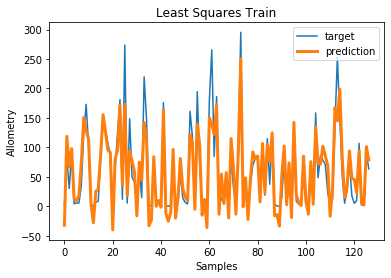

In [29]:
plot_fit(Ytrain_ls, Ttrain, title="Least Squares Train")

Based on the training plot above it seems least squares seems to be learning our training data pretty well!

Now it's time to see how least squares preforms on our test data.

In [30]:
Xstest = Xtest.copy() 

# Standardize testing data
Xstest[:, 3] = (Xtest[:, 3] - mu[3]) / sigma[3]
X1stest = np.hstack((np.ones((Ntest, 1)), Xstest))

# Make predictions for testing data using learning weights
Ytest_ls = X1stest @ w

RMSE: 26.081792709198684


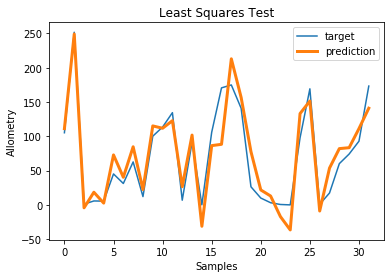

In [31]:
plot_fit(Ytest_ls, Ttest, title="Least Squares Test")

Nice, least squares seems replicating our test data closely as well! So far it looks like our linear regression method is setting a high bar. Let's now take a look at nonlinear regression.

# Apply Nonlinear Regression: Neural Networks

It's finally time to try out our nonlinear neural network algorithm. Since we are using a simple one layer neural network we will only have two weights, input weights $V$ and output weights $W$.

## Variables 

Here is a list of the variables,  shapes, and their description.

- $X : N \times D$ - Input Data without bias
    - $N$ is the number of data samples
    - $D$ is the number of features
- $X1 : N \times (D+1)$ - Input data with bias
    - $(D+1)$ is the number of features plus bias
- $V : (D+1) \times G$ - Input weights
    - Note: $G$ is the number of hidden units
- $Z : N \times G$ - First layer output
    - Note: Activation function is applied here
- $Z1 : N \times (G+1)$ - First layer output with bias
    - $(G+1)$ is the number of hidden units plus bias
- $W : (G+1) \times K$ - Output weights
    - $K$ is the number of outputs (for regression this is 1 and for classification this your number of classes)
- $Y : N \times K$ - Predictions
- $T : N \times K$ - Targets

## Forward Pass Steps

Recall the following steps for making a prediction, also called the forward pass, from the class notes.

1. Calculate first layer output by taking the dot product between the inputs $X1$ and input weights $V$. Then apply the activation function $\tanh$. 
$$Z = \tanh(X1 \cdot V)$$
2. Add bias to $Z$ to get $Z1$
3. Make your predictions by taking the dot product between the output of the first layer $Z1$ and the output weights $W$.
$$Y = Z1 \cdot W$$

## Backward Pass Equations

Recall the backward pass weight updates for $V$ and $W$ from the class notes.

$$ V \leftarrow V + \frac{\rho_v}{N*K}*{X1}^T \cdot ( (T - Y) \cdot W^T \odot (1 - Z^2) )$$

Here $N$ and $K$ are scalars and $\rho_v$ is our learning rate for our input weights $V$. In addition, $X1$ is our input data with bias added, $T$ is our target, $Y$ is our predictions, $W$ is the output weights, and $Z$ is the output of the first layer with the activation function applied. **Recall, that we remove the bias from $W$ for this update as we only take into account the bias for the current weight we are updating! (In the case, since we updating $V$, we only care about the bias for input weight $V$.)**

$$ W \leftarrow W + \frac{\rho_w}{N*K}*{Z1}^T \cdot (T - Y)$$

Here $N$ and $K$ are scalars and $\rho_w$ is our learning rate for our output weights $W$. In addition, $T$ is our target, $Y$ is our predictions, $Z1$ is the output of the first layer with the activation function applied and bias added. 

**Note that $\cdot$ refers to the dot product, $\odot$ refers to the element-wise multiplication, and $*$ refers to scalar multiplication.**

In [32]:
def addOnes(A):
    """Adds bias to passed data"""
    return np.insert(A, 0, 1, axis=1)


### TODO: 

If you're lost refer to the [class notes](https://nbviewer.jupyter.org/url/webpages.uncc.edu/mlee173/teach/itcs4156/notebooks/notes/Note-Neural%20Networks.ipynb)
or the above forward pass steps and backward pass equations. **Also, your plots/RMSE to not have to match ours, although they should be similar.**

**Forward pass TODOs:**

**Hint: Use the Forward Pass Steps section above!**

1. Calculate the the output of the first layer output $Z$. Here $X1$ corresponds to `X1strain` and the inputs weights $V$ correspond to `V`. Use the $\tanh$ activation function provided by Numpy `np.tanh()`. Store the output into `Z`.
    1. Hint: See forward pass step 1
<br><br>
2. Add the bias to the first layer output `Z` using the `addOnes()` function provided. Store output in `Z1`.
<br><br>
3. Compute the predictions of the neural network $Y$. Here $Z1$ corresponds to `Z1` and $W$ corresponds to `W`. Store the output into `Ytrain`.
    1. Hint: See forward pass step 3

**Backward pass TODOs:**

**Hint: Use the Backward Pass Equations section above!**

1. Calculate the update for the input weights $V$. Here $\frac{\rho_v}{N*K}$ corresponds to `rho_v_scaled`, $X1$ corresponds to ` X1strain`, $(T - Y)$ corresponds to `error`, $W$ corresponds to `W`, and $Z$ corresponds to `Z`.  Update the value stored in `V`.
    1. Hint: If you are getting `ValueError: operands could not be broadcast together with shapes (127,6) (127,5)` this is because $(T - Y) \cdot W^T$ produces a matrix with the shape $N \times (G+1)$ and $(1-Z^2)$ has a shape$N \times G$. Thus, $ (T - Y) \cdot W^T \odot (1 - Z^2)$ will have incompatible shapes for element-wise multiplication.  Remember, we must remove bias from the weight $W$ for this update. Try indexing everything but the first column of $W$.
<br><br>
2. Calculate the update for the output weights $W$. Here $Z1$ corresponds to `Z1` and $(T - Y)$ corresponds to `error` and $\frac{\rho_w}{N*K}$ refers to `rho_w_scaled`. Update the value stored in `W`.

In [35]:
# N, D, Ntrain, and Ntest were all previously set
# Now, set the number of outputs, which will be one since we are preforming regression
K = Ttrain.shape[1] if len(Ttrain.shape) == 2 else 1

# Set parameters of neural network
hidden_units = 5

rho_v = 0.01
rho_w = 0.01

rho_v_scaled = rho_v / (Ntrain*K)
rho_w_scaled = rho_w / (Ntrain*K)

# Number of graident descent steps to take when searching for a minimum in mean-squared-error space
steps = 30000

###########################################################################
# Initialize weights to uniformly distributed values between small normally-distributed between -0.1 and 0.1
V = 0.1*2*(np.random.uniform(size=(D+1,hidden_units))-0.5)
W = 0.1*2*(np.random.uniform(size=(1+hidden_units,K))-0.5)

###########################################################################
# collect training and testing errors for plotting
errorTrace = np.zeros((steps,2))

fig = plt.figure(figsize=(10,8))
for s in range(steps):

    # Forward pass on training data
    # TODO (1)
    Z = 
    # TODO (2)
    Z1 = 
    # TODO (3)
    Ytrain = 

    # Error in output
    error = Ttrain - Ytrain

    # Backward pass - the backpropagation and weight update steps
    # TODO (4)
    V =
    # TODO (5)
    W =       

    # Train error trace for plotting later
    errorTrace[s,0] = np.sqrt(np.mean((error**2)))
    
    # Test error trace for plotting later
    Ytest = addOnes(np.tanh(X1stest @ V)) @ W  # Forward pass in one line!
    errorTrace[s,1] = np.sqrt(np.mean((Ytest-Ttest)**2))

<Figure size 720x576 with 0 Axes>

### Observing the learning curve: 
Alright, now lets plot the train and test errors we got after every gradient decent update! Recall the number of gradient decent updates corresponds to the variable `steps` above.

If our algorithm is learning the correct weights we should observe our training error decreases over time. Likewise, we should see our testing error decrease as well. If our test error starts to increase while our training error continues to decrease this indicates overfitting.

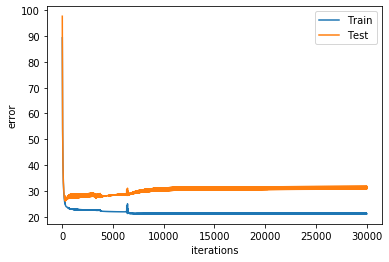

In [42]:
plt.plot(errorTrace)
plt.legend(('Train','Test'))
plt.xlabel("iterations")
plt.ylabel("error");

What do you think about your learning curve? Do you see the network overfitting at all?

Let's now compare our training predictions and targets.

RMSE: 21.335311840110254


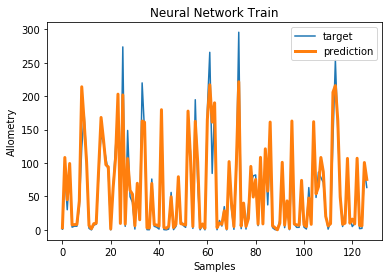

In [41]:
Ytrain_nn = addOnes(np.tanh(X1strain @ V)) @ W  #!! Forward pass in one line

plot_fit(Ytrain_nn, Ttrain, title="Neural Network Train")


Well, our weights seem to learn the training data cloesly just like linear regression. The weights seem to even start capturing the spikes in our targets. For example, check out the 45th, 60th, and 90th sample spikes. 

Now let's check our test predications and their targets. Take a second to think about how well our test predictions and targets match-up.

RMSE: 31.72639155228665


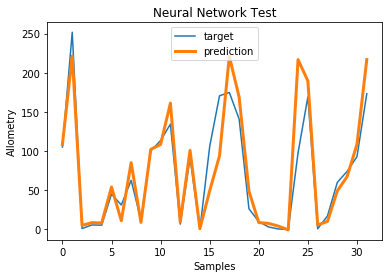

In [44]:
Ytest_nn = addOnes(np.tanh(X1stest @ V)) @ W  #!! Forward pass in one line

plot_fit(Ytest_nn, Ttest, title="Neural Network Test")


# Analysis: 
Run the following code cells to re-plot your linear and nonlinear regression test predictions and RMSE. Which model do you think fits the data better, linear or nonlinear regression? 

RMSE: 26.081792709198684


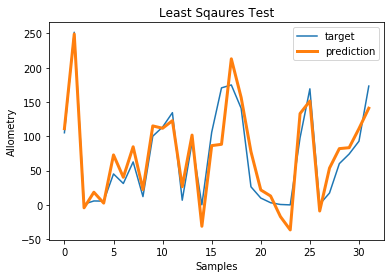

In [45]:
# linear regression: least sqaures
plot_fit(Ytest_ls, Ttest, title="Least Sqaures Test")

RMSE: 31.72639155228665


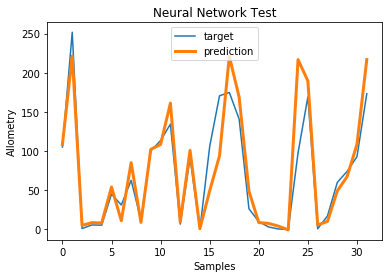

In [46]:
# nonlinear regression: neural network
plot_fit(Ytest_nn, Ttest,  title="Neural Network Test")

If you have extra time or simply want to learn about tuning parameters for neural networks we highly recommend trying out these bonus exercises (these are not graded).

### BONUS TODO (1): 
You may not notice a large difference between the models. You might even see that the nonlinear regression algorithm is overfitting.

Try adjusting the number of hidden units by changing the value of `hidden_units` to 10, 50, and 100. Do you notice any differences in the test RMSE and plot? Does your neural network seem to be overfitting more or less?

### BONUS TODO (2):

Now, let's try stopping a bit earlier. Let's try to stop before our test error increases while training error still decreases, as this is sign of overfitting.

Try decreasing the number of gradient decent steps by adjusting the `steps` variable. Try using 15k, 5k, and 500. Notice any changes in the prediction plots or RMSE? 